In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from scipy.interpolate import Rbf
from numpy import random

### Consider the Vander Pol Oscillator given by the equations:

$\dot{x_1} = 2x_2$

$\dot{x_2} = -0.8x_1+2x_2-10x_1^2x_2+u$

In [2]:
# define the dynamics
vanderpol = lambda t,x,u : np.asarray([2*x[1],-0.8*x[0]+2*x[1]-10*x[0]**2*x[1]+u])

In [3]:
dt = 0.01 # sampling time
nstates = 2 # number of states
nctrl = 1 # number of control inputs

### Define some helper functions

In [4]:
# RK4
k1 = lambda t,x,u: vanderpol(t,x,u)
k2 = lambda t,x,u: vanderpol(t,x+k1(t,x,u)*dt/2,u)
k3 = lambda t,x,u: vanderpol(t,x+k2(t,x,u)*dt/2,u)
k4 = lambda t,x,u: vanderpol(t,x+k1(t,x,u)*dt,u)
rk4_step = lambda t,x,u: x+(dt/6)*(k1(t,x,u)+2*k2(t,x,u)+2*k3(t,x,u)+k4(t,x,u))

In [77]:
# define the Radial Basis Function that will aid in lifting the states
def rbf(X,C,rbf_type):
    
    Cbig = C ; Y = np.zeros([C.shape[1],X.shape[1]])
    
    for i in range(Cbig.shape[1]):
        
        C = np.asarray([Cbig[:,i]]).T
        C = np.tile(C,X.shape[1])
        r_squared = np.sum((X-C)**2,axis = 0)
        
        r_squared = np.reshape(r_squared,(1,len(r_squared)))
        y = r_squared*np.log(np.sqrt(r_squared))
        
        Y[i,:] = y
    
    return Y

In [78]:
Nrbf = 100 # number of RBF centers
cent = np.random.uniform(0,1,[nstates,Nrbf])*2-1 # generate random RBF centers
rbf_type = 'thin_plate' # specify the type of RBF

# obtain the lifted states
liftFun = lambda xx,cent: np.vstack([xx,rbf(xx,cent,rbf_type)])
# update the total dimension of the lifted state vector
Nlift = Nrbf+nstates

### Collect Data

In [97]:
Nsim = 200
Ntraj = 1000

# Random forcing
Ubig = 2*np.random.uniform(0,1,[Nsim,Ntraj]) - 1

# Random initial conditions
Xcurrent = (np.random.uniform(0,1,[nstates,Ntraj])*2 - 1)

X = np.empty([nstates,Nsim*Ntraj]); Y = np.empty([nstates,Nsim*Ntraj])
U = np.empty([1,Nsim*Ntraj])

# collect trajectories
for i in range(Nsim):
    Xnext = rk4_step(0,Xcurrent,Ubig[i,:])
    X[:,i*Ntraj:(i+1)*Ntraj] = Xcurrent
    Y[:,i*Ntraj:(i+1)*Ntraj] = Xnext
    U[:,i*Ntraj:(i+1)*Ntraj] = Ubig[i,:]
    Xcurrent = Xnext

U = np.asarray(U)

### Lift

In [98]:
Xlift = liftFun(X,cent)
Ylift = liftFun(Y,cent)

### Build Predictor


In [109]:
W = np.vstack([Ylift,X])
V = np.vstack([Xlift,U])

VVt = np.dot(V,V.T)
WVt = np.dot(W,V.T)
M = np.dot(WVt,np.linalg.pinv(VVt)) # Matrix [A B; C 0]
Alift = M[0:Nlift,0:Nlift]
Blift = M[0:Nlift,Nlift:]
Clift = M[Nlift:,0:Nlift]

### Check Predictor Performance

In [163]:
Tmax = 3
Nsim = Tmax/dt
n = np.arange(0,Nsim+1)

u_dt = lambda i : ((-1)**(round(i/30))) # control signal

# Initial condition
x0 = np.asarray([0.5, 0.5])
x0 = np.reshape(x0,(2,1))
x_true = x0

# Lifted initial condition
xlift = liftFun(x0,cent)

In [164]:
# Simulate
for i in range(int(Nsim)):
    # Koopman predictor
    term1 = np.dot(Alift,np.asarray([xlift[:,-1]]).T)
    term2 = np.dot(Blift,u_dt(i))
    xlift = np.hstack([xlift, term1 + term2]) # Lifted dynamics
    
    # True dynamics
    x_true = np.hstack([x_true, rk4_step(0,np.asarray([x_true[:,-1]]).T,u_dt(i))]) # Lifted dynamics
    
x_koop = np.dot(Clift, xlift) # Koopman predictions

### Plot the Results

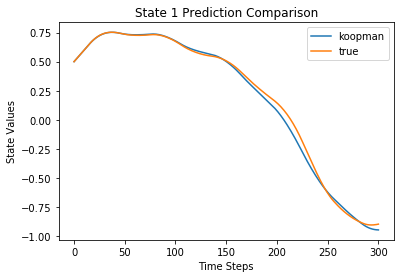

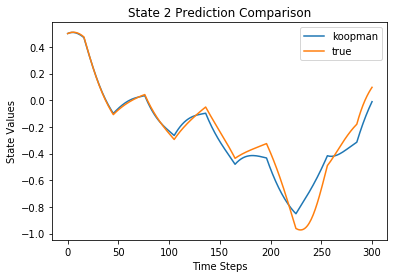

In [178]:
plt.plot(n,x_koop[0,:],label="koopman")
plt.plot(n,x_true[0,:],label="true")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("State Values")
plt.title("State 1 Prediction Comparison")
plt.show()

plt.plot(n,x_koop[1,:],label="koopman")
plt.plot(n,x_true[1,:],label="true")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("State Values")
plt.title("State 2 Prediction Comparison")
plt.show()